## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 100
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/e' + str(i))

print(models, model_names)

inputs = ['a', 'b', 'c', 'd', 'e', 'f']
target = ['g']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/e0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 173us/step - loss: 1.2934 - mean_squared_error: 1.2934 - val_loss: 1.1078 - val_mean_squared_error: 1.1078

Epoch 00001: val_loss improved from inf to 1.10783, saving model to temp/e0
Epoch 2/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1041 - mean_squared_error: 1.1041 - val_loss: 1.0693 - val_mean_squared_error: 1.0693

Epoch 00002: val_loss improved from 1.10783 to 1.06932, saving model to temp/e0
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0953 - mean_squared_error: 1.0953 - val_loss: 1.0937 - val_mean_squared_error: 1.0937

Epoch 00003: val_loss did not improve from 1.06932
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0828 - mean_squared_error: 1.0828 - val_loss: 1.0572 - val_mean_squared_error: 1.0572

Epoch 00004: val_loss improved from 1.06932 to 1.05715, sav

20000/20000 [==============================] - 3s 133us/step - loss: 1.0886 - mean_squared_error: 1.0886 - val_loss: 1.0795 - val_mean_squared_error: 1.0795

Epoch 00004: val_loss did not improve from 1.07824
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0841 - mean_squared_error: 1.0841 - val_loss: 1.0643 - val_mean_squared_error: 1.0643

Epoch 00005: val_loss improved from 1.07824 to 1.06429, saving model to temp/e5
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0898 - mean_squared_error: 1.0898 - val_loss: 1.0939 - val_mean_squared_error: 1.0939

Epoch 00006: val_loss did not improve from 1.06429
Epoch 7/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0827 - mean_squared_error: 1.0827 - val_loss: 1.0683 - val_mean_squared_error: 1.0683

Epoch 00007: val_loss did not improve from 1.06429
Epoch 00007: early stopping
temp/e6
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000

20000/20000 [==============================] - 3s 131us/step - loss: 1.0841 - mean_squared_error: 1.0841 - val_loss: 1.0645 - val_mean_squared_error: 1.0645

Epoch 00007: val_loss did not improve from 1.05876
Epoch 00007: early stopping
temp/e11
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.2669 - mean_squared_error: 1.2669 - val_loss: 1.0845 - val_mean_squared_error: 1.0845

Epoch 00001: val_loss improved from inf to 1.08454, saving model to temp/e11
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0987 - mean_squared_error: 1.0987 - val_loss: 1.0761 - val_mean_squared_error: 1.0761

Epoch 00002: val_loss improved from 1.08454 to 1.07612, saving model to temp/e11
Epoch 3/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0904 - mean_squared_error: 1.0904 - val_loss: 1.0736 - val_mean_squared_error: 1.0736

Epoch 00003: val_loss improved from 1.0


Epoch 00003: val_loss improved from 1.09432 to 1.06039, saving model to temp/e16
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0862 - mean_squared_error: 1.0862 - val_loss: 1.0979 - val_mean_squared_error: 1.0979

Epoch 00004: val_loss did not improve from 1.06039
Epoch 5/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0797 - mean_squared_error: 1.0797 - val_loss: 1.0591 - val_mean_squared_error: 1.0591

Epoch 00005: val_loss improved from 1.06039 to 1.05913, saving model to temp/e16
Epoch 6/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0891 - mean_squared_error: 1.0891 - val_loss: 1.1006 - val_mean_squared_error: 1.1006

Epoch 00006: val_loss did not improve from 1.05913
Epoch 7/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0836 - mean_squared_error: 1.0836 - val_loss: 1.0871 - val_mean_squared_error: 1.0871

Epoch 00007: val_loss did not improve from 1.05913
Epoch 00


Epoch 00005: val_loss did not improve from 1.06763
Epoch 00005: early stopping
temp/e22
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.2695 - mean_squared_error: 1.2695 - val_loss: 1.0819 - val_mean_squared_error: 1.0819

Epoch 00001: val_loss improved from inf to 1.08191, saving model to temp/e22
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0940 - mean_squared_error: 1.0940 - val_loss: 1.0818 - val_mean_squared_error: 1.0818

Epoch 00002: val_loss improved from 1.08191 to 1.08180, saving model to temp/e22
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0909 - mean_squared_error: 1.0909 - val_loss: 1.0687 - val_mean_squared_error: 1.0687

Epoch 00003: val_loss improved from 1.08180 to 1.06868, saving model to temp/e22
Epoch 4/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0886 - mean_squared_error: 1.0886

20000/20000 [==============================] - 3s 130us/step - loss: 1.0902 - mean_squared_error: 1.0902 - val_loss: 1.1059 - val_mean_squared_error: 1.1059

Epoch 00005: val_loss did not improve from 1.06860
Epoch 6/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0843 - mean_squared_error: 1.0843 - val_loss: 1.0548 - val_mean_squared_error: 1.0548

Epoch 00006: val_loss improved from 1.06860 to 1.05479, saving model to temp/e27
Epoch 7/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0816 - mean_squared_error: 1.0816 - val_loss: 1.0748 - val_mean_squared_error: 1.0748

Epoch 00007: val_loss did not improve from 1.05479
Epoch 8/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0738 - mean_squared_error: 1.0738 - val_loss: 1.0747 - val_mean_squared_error: 1.0747

Epoch 00008: val_loss did not improve from 1.05479
Epoch 00008: early stopping
temp/e28
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
200


Epoch 00002: val_loss improved from 1.14492 to 1.07111, saving model to temp/e33
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0940 - mean_squared_error: 1.0940 - val_loss: 1.0801 - val_mean_squared_error: 1.0801

Epoch 00003: val_loss did not improve from 1.07111
Epoch 4/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0867 - mean_squared_error: 1.0867 - val_loss: 1.0991 - val_mean_squared_error: 1.0991

Epoch 00004: val_loss did not improve from 1.07111
Epoch 00004: early stopping
temp/e34
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.2550 - mean_squared_error: 1.2550 - val_loss: 1.0900 - val_mean_squared_error: 1.0900

Epoch 00001: val_loss improved from inf to 1.09004, saving model to temp/e34
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.1033 - mean_squared_error: 1.1033 - val_loss: 1.0733 - val_mean

20000/20000 [==============================] - 3s 144us/step - loss: 1.2780 - mean_squared_error: 1.2780 - val_loss: 1.1187 - val_mean_squared_error: 1.1187

Epoch 00001: val_loss improved from inf to 1.11871, saving model to temp/e41
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.1068 - mean_squared_error: 1.1068 - val_loss: 1.0888 - val_mean_squared_error: 1.0888

Epoch 00002: val_loss improved from 1.11871 to 1.08879, saving model to temp/e41
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0948 - mean_squared_error: 1.0948 - val_loss: 1.1086 - val_mean_squared_error: 1.1086

Epoch 00003: val_loss did not improve from 1.08879
Epoch 4/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0909 - mean_squared_error: 1.0909 - val_loss: 1.0690 - val_mean_squared_error: 1.0690

Epoch 00004: val_loss improved from 1.08879 to 1.06897, saving model to temp/e41
Epoch 5/20
20000/20000 [=====================

20000/20000 [==============================] - 3s 130us/step - loss: 1.0832 - mean_squared_error: 1.0832 - val_loss: 1.0683 - val_mean_squared_error: 1.0683

Epoch 00007: val_loss did not improve from 1.05762
Epoch 8/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0805 - mean_squared_error: 1.0805 - val_loss: 1.0690 - val_mean_squared_error: 1.0690

Epoch 00008: val_loss did not improve from 1.05762
Epoch 00008: early stopping
temp/e46
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.2771 - mean_squared_error: 1.2771 - val_loss: 1.1280 - val_mean_squared_error: 1.1280

Epoch 00001: val_loss improved from inf to 1.12799, saving model to temp/e46
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0990 - mean_squared_error: 1.0990 - val_loss: 1.0737 - val_mean_squared_error: 1.0737

Epoch 00002: val_loss improved from 1.12799 to 1.07366, saving model 

20000/20000 [==============================] - 3s 131us/step - loss: 1.0986 - mean_squared_error: 1.0986 - val_loss: 1.1015 - val_mean_squared_error: 1.1015

Epoch 00002: val_loss did not improve from 1.08925
Epoch 3/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0921 - mean_squared_error: 1.0921 - val_loss: 1.1313 - val_mean_squared_error: 1.1313

Epoch 00003: val_loss did not improve from 1.08925
Epoch 00003: early stopping
temp/e53
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.2735 - mean_squared_error: 1.2735 - val_loss: 1.0747 - val_mean_squared_error: 1.0747

Epoch 00001: val_loss improved from inf to 1.07468, saving model to temp/e53
Epoch 2/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.1079 - mean_squared_error: 1.1079 - val_loss: 1.0672 - val_mean_squared_error: 1.0672

Epoch 00002: val_loss improved from 1.07468 to 1.06722, saving model 


Epoch 00001: val_loss improved from inf to 1.09986, saving model to temp/e59
Epoch 2/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.1013 - mean_squared_error: 1.1013 - val_loss: 1.1180 - val_mean_squared_error: 1.1180

Epoch 00002: val_loss did not improve from 1.09986
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0819 - mean_squared_error: 1.0819 - val_loss: 1.1055 - val_mean_squared_error: 1.1055

Epoch 00003: val_loss did not improve from 1.09986
Epoch 00003: early stopping
temp/e60
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 147us/step - loss: 1.2771 - mean_squared_error: 1.2771 - val_loss: 1.1004 - val_mean_squared_error: 1.1004

Epoch 00001: val_loss improved from inf to 1.10038, saving model to temp/e60
Epoch 2/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0933 - mean_squared_error: 1.0933 - val_loss: 1.1170 - val_mean_squ

20000/20000 [==============================] - 3s 132us/step - loss: 1.0835 - mean_squared_error: 1.0835 - val_loss: 1.0740 - val_mean_squared_error: 1.0740

Epoch 00007: val_loss did not improve from 1.06077
Epoch 8/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0772 - mean_squared_error: 1.0772 - val_loss: 1.0627 - val_mean_squared_error: 1.0627

Epoch 00008: val_loss did not improve from 1.06077
Epoch 00008: early stopping
temp/e66
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.2660 - mean_squared_error: 1.2660 - val_loss: 1.1386 - val_mean_squared_error: 1.1386

Epoch 00001: val_loss improved from inf to 1.13862, saving model to temp/e66
Epoch 2/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.1022 - mean_squared_error: 1.1022 - val_loss: 1.0731 - val_mean_squared_error: 1.0731

Epoch 00002: val_loss improved from 1.13862 to 1.07306, saving model 

20000/20000 [==============================] - 3s 132us/step - loss: 1.0858 - mean_squared_error: 1.0858 - val_loss: 1.0634 - val_mean_squared_error: 1.0634

Epoch 00004: val_loss improved from 1.07596 to 1.06344, saving model to temp/e72
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0859 - mean_squared_error: 1.0859 - val_loss: 1.0583 - val_mean_squared_error: 1.0583

Epoch 00005: val_loss improved from 1.06344 to 1.05828, saving model to temp/e72
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0774 - mean_squared_error: 1.0774 - val_loss: 1.1083 - val_mean_squared_error: 1.1083

Epoch 00006: val_loss did not improve from 1.05828
Epoch 7/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0819 - mean_squared_error: 1.0819 - val_loss: 1.0791 - val_mean_squared_error: 1.0791

Epoch 00007: val_loss did not improve from 1.05828
Epoch 00007: early stopping
temp/e73
Train on 20000 samples, validate o


Epoch 00003: val_loss improved from 1.08338 to 1.07219, saving model to temp/e78
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0928 - mean_squared_error: 1.0928 - val_loss: 1.0812 - val_mean_squared_error: 1.0812

Epoch 00004: val_loss did not improve from 1.07219
Epoch 5/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0865 - mean_squared_error: 1.0865 - val_loss: 1.0698 - val_mean_squared_error: 1.0698

Epoch 00005: val_loss improved from 1.07219 to 1.06977, saving model to temp/e78
Epoch 6/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0846 - mean_squared_error: 1.0846 - val_loss: 1.0578 - val_mean_squared_error: 1.0578

Epoch 00006: val_loss improved from 1.06977 to 1.05777, saving model to temp/e78
Epoch 7/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0780 - mean_squared_error: 1.0780 - val_loss: 1.0607 - val_mean_squared_error: 1.0607

Epoch 00007: val_loss did not

20000/20000 [==============================] - 3s 132us/step - loss: 1.0826 - mean_squared_error: 1.0826 - val_loss: 1.0566 - val_mean_squared_error: 1.0566

Epoch 00005: val_loss improved from 1.05872 to 1.05656, saving model to temp/e83
Epoch 6/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0776 - mean_squared_error: 1.0776 - val_loss: 1.1243 - val_mean_squared_error: 1.1243

Epoch 00006: val_loss did not improve from 1.05656
Epoch 7/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0809 - mean_squared_error: 1.0809 - val_loss: 1.0757 - val_mean_squared_error: 1.0757

Epoch 00007: val_loss did not improve from 1.05656
Epoch 00007: early stopping
temp/e84
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 1.3013 - mean_squared_error: 1.3013 - val_loss: 1.0931 - val_mean_squared_error: 1.0931

Epoch 00001: val_loss improved from inf to 1.09306, saving model 


Epoch 00004: val_loss improved from 1.08817 to 1.06265, saving model to temp/e89
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0880 - mean_squared_error: 1.0880 - val_loss: 1.1140 - val_mean_squared_error: 1.1140

Epoch 00005: val_loss did not improve from 1.06265
Epoch 6/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0879 - mean_squared_error: 1.0879 - val_loss: 1.0865 - val_mean_squared_error: 1.0865

Epoch 00006: val_loss did not improve from 1.06265
Epoch 00006: early stopping
temp/e90
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.2607 - mean_squared_error: 1.2607 - val_loss: 1.1206 - val_mean_squared_error: 1.1206

Epoch 00001: val_loss improved from inf to 1.12061, saving model to temp/e90
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0913 - mean_squared_error: 1.0913 - val_loss: 1.0645 - val_mean


Epoch 00007: val_loss did not improve from 1.05966
Epoch 00007: early stopping
temp/e95
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.2710 - mean_squared_error: 1.2710 - val_loss: 1.0863 - val_mean_squared_error: 1.0863

Epoch 00001: val_loss improved from inf to 1.08631, saving model to temp/e95
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0943 - mean_squared_error: 1.0943 - val_loss: 1.0730 - val_mean_squared_error: 1.0730

Epoch 00002: val_loss improved from 1.08631 to 1.07297, saving model to temp/e95
Epoch 3/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0898 - mean_squared_error: 1.0898 - val_loss: 1.1687 - val_mean_squared_error: 1.1687

Epoch 00003: val_loss did not improve from 1.07297
Epoch 4/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0843 - mean_squared_error: 1.0843 - val_loss: 1.0592 - val_mean

In [25]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 0.5, 1.0, 1.5, 2]
variances = [1, 1.5, 2, 2.5, 3, 3.5]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 500
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = norm(get_shap(model, x_test2, nshap))
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/e0
0.005346127102404122
[0.00644983 0.00883409 0.00567662 0.01856053 0.00779394 0.95268499]
temp/e1
0.009161698969854476
[0.01050456 0.01181363 0.0042855  0.00863527 0.00682897 0.95793208]
temp/e2
0.003883703745105421
[0.00436824 0.01402265 0.00297787 0.03289669 0.00639939 0.93933515]
temp/e3
0.009313478419213662
[0.00325805 0.01051219 0.00669377 0.00809984 0.00568138 0.96575477]
temp/e4
0.006078265301548251
[0.00927346 0.01054289 0.00868392 0.01710818 0.00358011 0.95081144]
temp/e5
0.006952173174431495
[0.01088001 0.01137252 0.00905803 0.01347631 0.00459025 0.95062288]
temp/e6
0.009072860965166329
[0.01048488 0.00794717 0.00579573 0.01094537 0.00327514 0.96155171]
temp/e7
0.006135595105466677
[0.00616841 0.00730651 0.00517897 0.01677721 0.00687186 0.95769704]
temp/e8
0.0068263002044649445
[0.00790715 0.00630398 0.00410673 0.019286   0.0033632  0.95903295]
temp/e9
0.006760539614045738
[0.00942324 0.01860148 0.00361528 0.02467098 0.00344895 0.94024008]
temp/e10
0.00894

0.006471834210494715
[0.0138228  0.00721404 0.0032454  0.03808554 0.00399992 0.9336323 ]
temp/e85
0.005479909832492975
[0.01065649 0.01250808 0.00850907 0.01776916 0.0047142  0.94584302]
temp/e86
0.006186198229791271
[0.00884626 0.01118793 0.00513098 0.01658595 0.00891474 0.94933413]
temp/e87
0.008698816721632674
[0.00389894 0.00907521 0.00479392 0.01127711 0.00560706 0.96534777]
temp/e88
0.005713925572322618
[0.00359202 0.01704065 0.00946208 0.01815548 0.00447246 0.94727731]
temp/e89
0.010121208393407891
[0.00599296 0.00626738 0.00395795 0.0086041  0.00430916 0.97086846]
temp/e90
0.007440901208890404
[0.00632282 0.01092869 0.00625666 0.01314271 0.00551275 0.95783636]
temp/e91
0.010247316432406462
[0.01226495 0.0174443  0.00322204 0.00704347 0.00622737 0.95379787]
temp/e92
0.00918332966882375
[0.0086788  0.01466994 0.00580728 0.01062044 0.00325712 0.95696643]
temp/e93
0.008995513160971573
[0.01100888 0.00907883 0.00463845 0.01075766 0.00485217 0.959664  ]
temp/e94
0.006757816319252335


0.010209141378196437
[0.00961806 0.01631342 0.00320124 0.00825552 0.00515064 0.95746111]
temp/e69
0.00577135492334858
[0.00313426 0.0143808  0.00651063 0.02208004 0.00263447 0.95125979]
temp/e70
0.005715387216826603
[0.00406799 0.00652484 0.0040089  0.02113769 0.00531274 0.95894784]
temp/e71
0.005534274572979732
[0.00616496 0.01588017 0.01061253 0.02941892 0.0023795  0.93554392]
temp/e72
0.007679353375555575
[0.00732986 0.01249925 0.00356838 0.01419863 0.00642976 0.95597412]
temp/e73
0.007629780520011759
[0.00516925 0.01316939 0.00413999 0.01505032 0.00515518 0.95731588]
temp/e74
0.004531409580775746
[0.01211836 0.00921896 0.0082979  0.02690401 0.00399471 0.93946605]
temp/e75
0.007849542698102842
[0.00805739 0.01123216 0.00683558 0.00989132 0.00710876 0.95687479]
temp/e76
0.009405311311673166
[0.00446395 0.01031258 0.0040692  0.01103908 0.00391061 0.96620458]
temp/e77
0.011465528699492392
[0.00235569 0.0229358  0.0150015  0.00354915 0.00306031 0.95309755]
temp/e78
0.007977731030678286


0.007618323204770465
[0.00523615 0.01437101 0.01522737 0.00983244 0.00623568 0.94909735]
temp/e53
0.007394288445419087
[0.0116541  0.00687849 0.00585257 0.0144366  0.00476279 0.95641545]
temp/e54
0.0044637376890838834
[0.00669818 0.010134   0.00666864 0.02358732 0.00358766 0.9493242 ]
temp/e55
0.0092183907226115
[0.02039226 0.01079477 0.01011083 0.01482277 0.00937145 0.93450792]
temp/e56
0.009484639703631602
[0.00851054 0.01552174 0.00383498 0.01140405 0.00354187 0.95718681]
temp/e57
0.005104340292014314
[0.0082851  0.01306122 0.00372181 0.02427189 0.00392811 0.94673187]
temp/e58
0.005327749936015866
[0.00859398 0.00974777 0.01146249 0.01759594 0.0053439  0.94725592]
temp/e59
0.008581165557466096
[0.00326121 0.02365015 0.00357332 0.03736157 0.00308707 0.92906667]
temp/e60
0.008499482479704746
[0.00452092 0.01507799 0.00418969 0.01058739 0.00713252 0.95849148]
temp/e61
0.008507069955371491
[0.00728648 0.00756565 0.01014113 0.00802056 0.00538132 0.96160486]
temp/e62
0.004472272064228212


0.0064400408333381036
[0.00618689 0.00435957 0.00463144 0.02020919 0.00307407 0.96153883]
temp/e37
0.004169016286212285
[0.00575165 0.01213504 0.00360698 0.0241615  0.00779391 0.94655092]
temp/e38
0.00767113312899563
[0.0053883  0.00839399 0.00484115 0.01296141 0.00641886 0.96199627]
temp/e39
0.00961845569459928
[0.00369396 0.01894334 0.00819745 0.00766435 0.00326235 0.95823855]
temp/e40
0.005377497624848785
[0.00549927 0.01672775 0.00996031 0.02512032 0.00285093 0.93984142]
temp/e41
0.01053305198810471
[0.00548931 0.01389089 0.00338183 0.00854334 0.0037105  0.96498413]
temp/e42
0.00648974953358502
[0.00530336 0.01298922 0.00569866 0.01612425 0.00594267 0.95394184]
temp/e43
0.00626134499686319
[0.00821801 0.01571944 0.00631406 0.01828328 0.00385346 0.94761175]
temp/e44
0.008241001397320582
[0.00741433 0.01220023 0.00291182 0.01264071 0.00708679 0.95774613]
temp/e45
0.008542637082789538
[0.00424133 0.01269561 0.00361781 0.01531928 0.00286714 0.96125882]
temp/e46
0.005171008121478811
[0.

0.00437989484289456
[0.00458664 0.00747742 0.00865768 0.0188241  0.00880108 0.95165309]
temp/e21
0.007028062083293263
[0.002351   0.01095023 0.01375582 0.01296725 0.00705433 0.95292137]
temp/e22
0.009118620878805142
[0.00626967 0.01281923 0.00599465 0.00925402 0.0046303  0.96103213]
temp/e23
0.005269979460310701
[0.00448513 0.01425454 0.00360111 0.02359832 0.00422546 0.94983544]
temp/e24
0.008485046459224538
[0.0040876  0.00943165 0.00354086 0.01435727 0.0042326  0.96435002]
temp/e25
0.008142050511744785
[0.00687179 0.0207077  0.00929728 0.01219675 0.00230019 0.9486263 ]
temp/e26
0.005768091611946957
[0.00912884 0.01055636 0.00623491 0.01955501 0.00414064 0.95038425]
temp/e27
0.008665150750458898
[0.00858802 0.00640125 0.00450621 0.01160755 0.00512562 0.96377136]
temp/e28
0.00725036673928145
[0.00652863 0.00758139 0.01003278 0.01021268 0.00734074 0.95830378]
temp/e29
0.007620034758432127
[0.00537551 0.00382385 0.00507654 0.01489589 0.00440229 0.96642592]
temp/e30
0.006189000415398661
[

0.005287210096846437
[0.009156   0.01086567 0.00921246 0.01964442 0.00341704 0.94770441]
temp/e5
0.0059317841793947385
[0.01135586 0.01139541 0.00908672 0.01598539 0.00514235 0.94703427]
temp/e6
0.008459444772299022
[0.01139445 0.00986847 0.00551623 0.0130355  0.00330477 0.95688059]
temp/e7
0.005425573629518526
[0.00671776 0.00685736 0.00518818 0.01937024 0.00639969 0.95546677]
temp/e8
0.0065940880266768505
[0.00740465 0.00562157 0.00389789 0.01997675 0.00357792 0.95952121]
temp/e9
0.006568026270292032
[0.01024109 0.01720609 0.00360839 0.02783745 0.00372561 0.93738137]
temp/e10
0.008212164882804804
[0.00736442 0.01054536 0.00662354 0.01158194 0.00439285 0.95949188]
temp/e11
0.00728422233197272
[0.00482632 0.009807   0.00419589 0.01664834 0.00453792 0.95998452]
temp/e12
0.005048810473756605
[0.00634146 0.01162278 0.00775335 0.02010763 0.00422741 0.94994736]
temp/e13
0.007528349960072139
[0.00607587 0.01124977 0.00914316 0.0121034  0.00423464 0.95719316]
temp/e14
0.007239648767862571
[0.

0.0047371179221657985
[0.003461   0.01596696 0.00986059 0.02167875 0.00449559 0.94453712]
temp/e89
0.009718498504818578
[0.00599828 0.00655025 0.00404178 0.0093164  0.00472116 0.96937214]
temp/e90
0.0064291339852036765
[0.00619671 0.01244174 0.00600229 0.01695992 0.00498522 0.95341412]
temp/e91
0.009527772589461433
[0.01254225 0.01676046 0.00310891 0.00962617 0.00591643 0.95204577]
temp/e92
0.00866797081407229
[0.00892995 0.01474047 0.00554535 0.01225836 0.00342721 0.95509867]
temp/e93
0.008505625403411083
[0.01141726 0.00886799 0.00462833 0.0121608  0.00492883 0.9579968 ]
temp/e94
0.006252112152640602
[0.0075224  0.01187942 0.00656406 0.01716728 0.00474715 0.95211968]
temp/e95
0.0057431359372814685
[0.00691204 0.00790779 0.00579687 0.02048088 0.00372767 0.95517475]
temp/e96
0.00821327988269412
[0.00772014 0.01227406 0.00374891 0.01239846 0.00644762 0.95741082]
temp/e97
0.009157783403664785
[0.00656846 0.01650878 0.00579687 0.00821851 0.0057461  0.95716128]
temp/e98
0.00464024039030183

0.009250443874068474
[0.00391991 0.01042681 0.00551132 0.00753162 0.00949326 0.96311709]
temp/e73
0.007579953834715673
[0.00822559 0.00342868 0.00431834 0.01712289 0.00305373 0.96385076]
temp/e74
0.005761271527358007
[0.00933572 0.00300874 0.0060277  0.02092441 0.00329461 0.95740882]
temp/e75
0.010483646966313492
[0.00538104 0.00652623 0.01313748 0.00415219 0.00331996 0.96748311]
temp/e76
0.010406872314858128
[0.00493408 0.01102288 0.00447482 0.00639963 0.00513976 0.96802883]
temp/e77
0.009117678990639666
[0.00416584 0.01992052 0.01490585 0.00615473 0.00568814 0.94916493]
temp/e78
0.008853383885092296
[0.00341156 0.00745339 0.00515042 0.01380023 0.00275111 0.96743329]
temp/e79
0.00960947291243782
[0.00353761 0.00320506 0.00950219 0.00680062 0.00429447 0.97266005]
temp/e80
0.010003438671904022
[0.00701722 0.00811237 0.00496264 0.00979614 0.00246573 0.9676459 ]
temp/e81
0.01089390651445619
[0.00590525 0.00458466 0.00381208 0.00458441 0.00615661 0.97495698]
temp/e82
0.010305938166012675
[

0.009235721306409952
[0.00688274 0.01227316 0.00404607 0.01268206 0.00279954 0.96131643]
temp/e57
0.0073488796105845335
[0.00866874 0.00508765 0.00379331 0.01797507 0.0034198  0.96105542]
temp/e58
0.006062003064106434
[0.00523611 0.0040614  0.02268004 0.01898224 0.0092226  0.93981761]
temp/e59
0.007743158561495575
[0.00325178 0.02435751 0.0024734  0.03414019 0.00281273 0.93296438]
temp/e60
0.007379141242992081
[0.00458142 0.00990535 0.00740646 0.01073164 0.00715251 0.96022262]
temp/e61
0.009337401351910078
[0.00353666 0.00305008 0.01053092 0.00510793 0.00775599 0.97001842]
temp/e62
0.004997548859901939
[0.00879661 0.00402953 0.01463354 0.03555158 0.00575673 0.931232  ]
temp/e63
0.00895360277850925
[0.00218463 0.0059618  0.01499842 0.01047801 0.00383828 0.96253885]
temp/e64
0.005109062647670606
[0.00642049 0.00755611 0.00470321 0.02024513 0.00879432 0.95228073]
temp/e65
0.01001551562426785
[0.00361477 0.00922803 0.00584313 0.00922961 0.00293941 0.96914504]
temp/e66
0.00927049730816597
[

0.004607886868331776
[0.0052357  0.01086837 0.0118033  0.02204378 0.00305564 0.94699321]
temp/e41
0.010996117286842452
[0.00528511 0.00718845 0.00354233 0.00644138 0.00426276 0.97327996]
temp/e42
0.006581937023505601
[0.00468476 0.00876442 0.00731354 0.01514751 0.00502797 0.9590618 ]
temp/e43
0.008224166751828086
[0.00628014 0.00959024 0.00679241 0.01214633 0.00362359 0.9615673 ]
temp/e44
0.008856387132846229
[0.00678521 0.01478203 0.00343857 0.0102678  0.00766064 0.95706576]
temp/e45
0.007543550107292472
[0.00453429 0.0065331  0.0038546  0.0176534  0.00309618 0.96432843]
temp/e46
0.006781134050742187
[0.00513359 0.0085924  0.0042225  0.01570963 0.00833498 0.95800691]
temp/e47
0.004482739561505918
[0.00800799 0.00888207 0.01075419 0.01935517 0.0061197  0.94688088]
temp/e48
0.01009663532206634
[0.00293002 0.00952969 0.00470774 0.01068235 0.00306346 0.96908674]
temp/e49
0.008256412899597344
[0.00669166 0.00910474 0.01259409 0.01063212 0.00352173 0.95745566]
temp/e50
0.006768326832730694


0.007865231511400233
[0.00379834 0.00705692 0.00373453 0.01696706 0.00357785 0.96486529]
temp/e25
0.00833412356781009
[0.00677682 0.01814451 0.00990721 0.01169776 0.00222296 0.95125074]
temp/e26
0.006322084835509356
[0.00864566 0.01178964 0.00748713 0.01740964 0.0033718  0.95129612]
temp/e27
0.008752066185749745
[0.00710093 0.00432036 0.00461509 0.01087314 0.00549041 0.96760009]
temp/e28
0.008115088853923017
[0.00576852 0.00515358 0.01345271 0.00761852 0.00991268 0.95809399]
temp/e29
0.008033058332575846
[0.00381357 0.00291341 0.00702618 0.01310007 0.00402551 0.96912125]
temp/e30
0.008075317646620212
[0.00717435 0.00542905 0.00387261 0.0137282  0.00540806 0.96438772]
temp/e31
0.0054139099764512226
[0.00695068 0.00589678 0.00595323 0.0212715  0.00376837 0.95615945]
temp/e32
0.007782366641655714
[0.00936664 0.01066279 0.00364708 0.01328135 0.00979064 0.95325151]
temp/e33
0.007414996125977499
[0.00396775 0.00680856 0.00691644 0.01669995 0.00184435 0.96376295]
temp/e34
0.009374094626394247

0.008503910103579879
[0.00624201 0.00586195 0.00426761 0.0137276  0.00372788 0.96617294]
temp/e9
0.004828457337693906
[0.00925541 0.01297305 0.00423833 0.02577765 0.00357933 0.94417622]
temp/e10
0.008544538575666111
[0.00777596 0.00841549 0.00804083 0.00928108 0.00427931 0.96220733]
temp/e11
0.008628372752207273
[0.00520973 0.006199   0.00377825 0.01272884 0.00484262 0.96724157]
temp/e12
0.006041764833565629
[0.00693389 0.00839176 0.00765366 0.01685078 0.0046051  0.95556481]
temp/e13
0.008669064619402221
[0.00554275 0.01319566 0.01172929 0.00918958 0.00372631 0.9566164 ]
temp/e14
0.0082821205323835
[0.00927404 0.00530241 0.00430944 0.01176052 0.00631851 0.96303508]
temp/e15
0.004083227887100448
[0.00288502 0.00899138 0.00964127 0.02395682 0.0042702  0.9502553 ]
temp/e16
0.008121310327138712
[0.00489347 0.00561236 0.01068242 0.00759985 0.01022453 0.96098737]
temp/e17
0.007733476245138947
[0.00596962 0.00390167 0.00566155 0.01418649 0.00418636 0.96609431]
temp/e18
0.007386314758020772
[0

0.008992911877794807
[0.00921211 0.01052289 0.00581886 0.01154136 0.00289588 0.9600089 ]
temp/e93
0.00948305272461305
[0.00891674 0.00571968 0.00458508 0.00937484 0.00482575 0.96657791]
temp/e94
0.008090515348810692
[0.00689863 0.0087693  0.00647358 0.0121078  0.0043819  0.9613688 ]
temp/e95
0.006115627887156732
[0.00626394 0.00488846 0.00657823 0.01777985 0.00452987 0.95995965]
temp/e96
0.008874221154707554
[0.00809189 0.00870172 0.00387961 0.00977325 0.00822903 0.96132449]
temp/e97
0.009296155012877222
[0.00512307 0.01223531 0.00755542 0.00685524 0.00493571 0.96329526]
temp/e98
0.004584049023865378
[0.00343005 0.00865434 0.00564166 0.02224108 0.00660853 0.95342433]
temp/e99
0.002020803791055978
[0.00714673 0.00665878 0.00624259 0.03062175 0.00532161 0.94400855]
<<<<<<<< 0.5 3.5
temp/e0
0.005095449664992686
[0.00605931 0.0062002  0.00619977 0.01884042 0.00690829 0.95579201]
temp/e1
0.009037584829923041
[0.0126399  0.01193866 0.00355818 0.01051611 0.00604778 0.95529936]
temp/e2
0.00491

0.008844211990085019
[0.00527027 0.00912543 0.00394663 0.0120068  0.00474876 0.9649021 ]
temp/e77
0.010836064945257733
[0.00297922 0.02222672 0.0137816  0.00432324 0.00355107 0.95313814]
temp/e78
0.007212564636951998
[0.00712106 0.01133298 0.0034975  0.01780684 0.0042928  0.95594883]
temp/e79
0.007743182551970152
[0.00713006 0.00535548 0.0051701  0.01421247 0.00462272 0.96350918]
temp/e80
0.005299965083010227
[0.00614988 0.01462068 0.00421673 0.02343088 0.00368733 0.94789451]
temp/e81
0.008786382758481188
[0.00755894 0.00566176 0.00341638 0.01208303 0.00537626 0.96590362]
temp/e82
0.009047237524628928
[0.00671586 0.00882426 0.00419354 0.01187924 0.00402034 0.96436677]
temp/e83
0.005179883019956242
[0.00430577 0.01839312 0.00876272 0.01960998 0.00616785 0.94276056]
temp/e84
0.004977564216382852
[0.01005023 0.00723746 0.00291605 0.03735188 0.00424059 0.93820379]
temp/e85
0.006676563478167782
[0.01042314 0.00946164 0.00973305 0.01456337 0.00433002 0.95148876]
temp/e86
0.005949807889295872

0.006993567198799323
[0.0038726  0.01073953 0.00949958 0.01154913 0.01028927 0.9540499 ]
temp/e61
0.010477990048387028
[0.0025581  0.00202754 0.01113938 0.00368727 0.00728375 0.97330396]
temp/e62
0.006210187660125988
[0.00878387 0.00171489 0.0193937  0.0335594  0.00856706 0.92798107]
temp/e63
0.011276822324909896
[0.00167186 0.00395742 0.0184418  0.00268821 0.0051712  0.96806951]
temp/e64
0.008842913139848968
[0.00489565 0.00766062 0.00428544 0.00946135 0.00956993 0.96412701]
temp/e65
0.014129844092583175
[0.0013179  0.01224503 0.00277182 0.00312838 0.00206584 0.97847103]
temp/e66
0.010896988989151127
[0.00742867 0.00321618 0.00471788 0.00303615 0.0068781  0.97472302]
temp/e67
0.007530730255713959
[0.00137513 0.00283021 0.00815492 0.01800103 0.00202444 0.96761427]
temp/e68
0.012919756166441273
[0.00818526 0.01385301 0.00293764 0.00348301 0.00205491 0.96948617]
temp/e69
0.01118187115588361
[0.00308217 0.01513248 0.01653004 0.00267369 0.00406026 0.95852137]
temp/e70
0.004728902845291951


0.010717898237134425
[0.00391138 0.01851448 0.0030008  0.0056483  0.00887363 0.96005141]
temp/e45
0.008161235681567316
[0.00227471 0.00164201 0.00289212 0.02046918 0.0032162  0.96950578]
temp/e46
0.009524283922741638
[0.00416135 0.00500409 0.00519421 0.00678577 0.01233336 0.96652122]
temp/e47
0.00544117163877909
[0.00383095 0.00774154 0.01609311 0.0174839  0.00572337 0.94912713]
temp/e48
0.0109100215167343
[0.00130741 0.00653135 0.00636179 0.00704229 0.00423192 0.97452524]
temp/e49
0.008179680287558293
[0.00573665 0.00924825 0.01859745 0.0124315  0.00195254 0.9520336 ]
temp/e50
0.007823655842739582
[0.00473282 0.01217502 0.01759512 0.01190179 0.00355032 0.95004492]
temp/e51
0.008781528064402267
[0.00827427 0.00492853 0.01010392 0.00746473 0.00511377 0.96411477]
temp/e52
0.009717403030714085
[0.00716088 0.00423117 0.02356128 0.00529403 0.00447685 0.95527579]
temp/e53
0.004345338378202504
[0.01497511 0.00318738 0.01081129 0.02686126 0.00215013 0.94201483]
temp/e54
0.005602750781916504
[0

0.009245858849818595
[0.00450562 0.00225764 0.01575424 0.00527302 0.01277771 0.95943178]
temp/e29
0.009368158918815093
[0.00204486 0.00239957 0.0085794  0.01044791 0.00366936 0.9728589 ]
temp/e30
0.010501296538614771
[0.00551589 0.00260979 0.00332726 0.00890932 0.00418902 0.97544873]
temp/e31
0.0061734466940006
[0.00499685 0.00413981 0.00500807 0.01916718 0.00453924 0.96214886]
temp/e32
0.009344146227599909
[0.00790365 0.00741135 0.00255359 0.0096895  0.01049362 0.96194828]
temp/e33
0.009652518628804643
[0.00309735 0.00374065 0.00559308 0.01223406 0.00179143 0.97354343]
temp/e34
0.010874933974633363
[0.00219229 0.0078988  0.00722536 0.00624856 0.00338246 0.97305252]
temp/e35
0.0064256773316203495
[0.00155367 0.00877928 0.00299785 0.02098664 0.00685828 0.95882428]
temp/e36
0.007264508786878028
[0.00228632 0.0058602  0.00576697 0.01940572 0.00242094 0.96425985]
temp/e37
0.007526757835082988
[0.00601734 0.00360503 0.00359984 0.01466361 0.0063911  0.96572308]
temp/e38
0.008603075818606826


0.008161727170674066
[0.00665013 0.00623374 0.00674834 0.01251063 0.00349069 0.96436648]
temp/e13
0.01002481240681064
[0.00410336 0.01441554 0.01352829 0.0063802  0.00280374 0.95876888]
temp/e14
0.01019635459603775
[0.0056543  0.00399649 0.00387923 0.00832043 0.00444611 0.97370344]
temp/e15
0.003907140154326812
[0.00320747 0.00700348 0.01075979 0.02454497 0.00388788 0.95059642]
temp/e16
0.008345324029250785
[0.00391395 0.0037963  0.00902781 0.00745251 0.01126212 0.96454731]
temp/e17
0.009779305805818981
[0.00376349 0.00325046 0.00435301 0.01131867 0.00295438 0.97435999]
temp/e18
0.0077891702378384406
[0.00454152 0.01222432 0.00301351 0.01389451 0.01050667 0.95581948]
temp/e19
0.010402440306232436
[0.00404015 0.00460116 0.0062938  0.00482067 0.00531153 0.97493268]
temp/e20
0.008452580699107627
[0.00535011 0.00445125 0.00675384 0.01114721 0.00397604 0.96832155]
temp/e21
0.007764223720937967
[0.00275827 0.00404441 0.01036604 0.01035149 0.01320414 0.95927564]
temp/e22
0.011473501392606495


0.009887319902297166
[0.00722043 0.00579428 0.00358925 0.00702432 0.01021417 0.96615755]
temp/e97
0.010080891141753376
[0.00313513 0.00780032 0.00809807 0.00614386 0.00405375 0.97076888]
temp/e98
0.0060770749159936984
[0.00246463 0.01009734 0.00593484 0.01926252 0.00578027 0.95646041]
temp/e99
0.0009609581438354423
[0.00487136 0.00474912 0.00671637 0.03166202 0.00597356 0.94602756]
<<<<<<<< 1.0 3
temp/e0
0.006300334156896431
[0.005262   0.00310493 0.00862376 0.0137776  0.006444   0.96278771]
temp/e1
0.010164799281698686
[0.01384039 0.01405381 0.00344711 0.0083378  0.00495551 0.95536537]
temp/e2
0.0030681369871404895
[0.00383596 0.0095708  0.00321274 0.03460415 0.00345658 0.94531977]
temp/e3
0.01100529063095477
[0.00343025 0.01043972 0.00538578 0.0070624  0.00277917 0.97090268]
temp/e4
0.007087440617411283
[0.00560719 0.00504998 0.01077235 0.01505165 0.00260912 0.96090971]
temp/e5
0.006211751271464949
[0.00627643 0.00677789 0.00986957 0.01499303 0.0052948  0.95678827]
temp/e6
0.01007665

0.00806610430891772
[0.00626886 0.01040404 0.00445908 0.01582886 0.00274858 0.96029059]
temp/e81
0.010013985428828968
[0.00656147 0.00425743 0.00338676 0.00796579 0.00584032 0.97198822]
temp/e82
0.009965102901938507
[0.00494388 0.00534972 0.00540807 0.00838006 0.00355139 0.97236688]
temp/e83
0.005692386558204774
[0.00337863 0.01806071 0.01063264 0.01843108 0.0046003  0.94489664]
temp/e84
0.0029486407546343934
[0.00579037 0.00803348 0.0032165  0.03056221 0.00461019 0.94778724]
temp/e85
0.008144425464713426
[0.00814012 0.00488772 0.01186855 0.0114219  0.00306791 0.9606138 ]
temp/e86
0.007893096828437796
[0.00448476 0.00863998 0.00507255 0.01152369 0.01326061 0.95701842]
temp/e87
0.009479370632970321
[0.00448994 0.00620713 0.00386061 0.0102267  0.00470941 0.97050621]
temp/e88
0.007260604444904714
[0.0029785  0.00742082 0.01377344 0.01442505 0.00417637 0.95722582]
temp/e89
0.010547429405113093
[0.0040505  0.00331399 0.00316336 0.00699804 0.00581929 0.97665482]
temp/e90
0.008437058691889203

0.004254649517013247
[0.00617493 0.00690613 0.00449648 0.0230151  0.00711121 0.95229615]
temp/e65
0.009470554620578338
[0.00341496 0.00858162 0.00620855 0.01089671 0.00274158 0.96815657]
temp/e66
0.00875208071571086
[0.00657595 0.00942928 0.00383919 0.01261783 0.00452157 0.96301618]
temp/e67
0.004604836566705542
[0.00178584 0.00992408 0.00597436 0.02648643 0.00361233 0.95221695]
temp/e68
0.01086875892906874
[0.00774284 0.01183914 0.00373845 0.00714121 0.00374889 0.96578947]
temp/e69
0.0065415751736236545
[0.00239921 0.01514191 0.01018477 0.01845313 0.00288467 0.95093631]
temp/e70
0.0046141742609421225
[0.00332711 0.00333471 0.00421494 0.02402002 0.00626889 0.95883434]
temp/e71
0.003919504574060615
[0.00558589 0.01224288 0.00543463 0.03363663 0.00248217 0.9406178 ]
temp/e72
0.007775073200142742
[0.00487766 0.0109829  0.00444129 0.01250902 0.00772487 0.95946426]
temp/e73
0.008108117848950522
[0.00676301 0.00739984 0.00450072 0.01501165 0.0033981  0.96292667]
temp/e74
0.003660604090772736

0.006971645024061492
[0.00330991 0.00999977 0.0163734  0.01590601 0.00323088 0.95118003]
temp/e48
0.011030701162932192
[0.00130662 0.00677337 0.00724707 0.00645256 0.00357512 0.97464525]
temp/e49
0.008530343024418357
[7.19032371e-03 9.92037683e-03 1.87278528e-02 1.24691376e-02
 8.62918972e-04 9.50829390e-01]
temp/e50
0.009125042434059876
[0.00484257 0.01270857 0.01717848 0.00749108 0.00405687 0.95372242]
temp/e51
0.010382526932518696
[0.01085774 0.00331676 0.00885125 0.00306253 0.00471297 0.96919874]
temp/e52
0.009697752751879776
[0.00885036 0.00245502 0.02285427 0.00644265 0.0042366  0.9551611 ]
temp/e53
0.006428865298281603
[0.0166152  0.00315304 0.01195966 0.03542591 0.00115446 0.93169172]
temp/e54
0.0058481239618464005
[0.00433768 0.00404625 0.00906072 0.01609765 0.00538203 0.96107567]
temp/e55
0.01018771313534864
[0.02310953 0.00770162 0.01308446 0.00205621 0.00630373 0.94774445]
temp/e56
0.007769751767073331
[0.00944415 0.01327132 0.00546568 0.01707526 0.00138463 0.95335896]
temp

0.012337183227397868
[0.00499868 0.00151407 0.00261343 0.00607254 0.00332768 0.9814736 ]
temp/e31
0.00695085852828867
[0.00324014 0.00403786 0.00411346 0.016508   0.00728085 0.96481969]
temp/e32
0.011034669139432846
[0.0069607  0.00610596 0.00272257 0.00444895 0.01444153 0.9653203 ]
temp/e33
0.010936112579365902
[0.0027638  0.00320845 0.00633787 0.00801419 0.00184527 0.97783041]
temp/e34
0.01217105981971836
[0.00143671 0.00954963 0.01144641 0.00338657 0.00202527 0.9721554 ]
temp/e35
0.007559073119822288
[8.67659731e-04 5.85810623e-03 2.83993225e-03 1.83293632e-02
 7.05392296e-03 9.65051016e-01]
temp/e36
0.008102742967954126
[9.19105914e-04 5.48843769e-03 8.90416354e-03 1.63470731e-02
 1.78732539e-03 9.66553894e-01]
temp/e37
0.008744841549746836
[0.00728596 0.00246098 0.00474368 0.01014079 0.00703271 0.96833589]
temp/e38
0.00910719203696581
[0.00353098 0.01092449 0.00756668 0.00927704 0.0039772  0.96472361]
temp/e39
0.007566970104478381
[0.00150053 0.00265285 0.02060808 0.01774384 0.002

0.012111674335337412
[0.00365294 0.00362199 0.00383481 0.00462707 0.00322364 0.98103956]
temp/e15
0.003805925912189227
[0.00384736 0.00534116 0.01409467 0.0237132  0.0043834  0.94862022]
temp/e16
0.00890726539944069
[0.00277075 0.00193584 0.01004034 0.00827849 0.01297638 0.9639982 ]
temp/e17
0.011899332510990249
[0.00208696 0.00327762 0.00443587 0.00721249 0.00226699 0.98072007]
temp/e18
0.008158831661221411
[0.00487747 0.00989777 0.0029123  0.01288674 0.01244657 0.95697917]
temp/e19
0.010566428888296212
[0.00265562 0.00352341 0.00818084 0.00266493 0.0064728  0.9765024 ]
temp/e20
0.008270722164092007
[0.0046951  0.00413114 0.0067599  0.01171397 0.00394879 0.9687511 ]
temp/e21
0.007789677461757222
[0.0029462  0.00169152 0.01167982 0.01170013 0.01699675 0.95498559]
temp/e22
0.011865811857551858
[0.00584212 0.00268568 0.0055941  0.00374822 0.00291384 0.97921604]
temp/e23
0.006712848022599044
[0.00203637 0.00615242 0.00632978 0.02072045 0.00244833 0.96231265]
temp/e24
0.0074935923582320485

0.007337240345682265
[0.00155771 0.01225037 0.00790621 0.01373056 0.00646728 0.95808788]
temp/e99
0.0007662022947290877
[0.00382445 0.00287234 0.00864543 0.03071147 0.00726401 0.94668228]
<<<<<<<< 1.5 2.5
temp/e0
0.008510145597933035
[0.00509962 0.00235495 0.01231851 0.00839086 0.00595128 0.96588477]
temp/e1
0.011130317093743985
[0.01558701 0.01610378 0.00380196 0.00605358 0.00398833 0.95446533]
temp/e2
0.0039180115928385715
[0.00362228 0.00721993 0.00330942 0.03090606 0.00208168 0.95286063]
temp/e3
0.01051410217492448
[0.0043305  0.0135303  0.00641604 0.00749713 0.00188749 0.96633853]
temp/e4
0.007919246133249442
[0.00462105 0.00499945 0.0137658  0.01315132 0.00201402 0.96144835]
temp/e5
0.006426870558603588
[0.00451808 0.00661026 0.00988411 0.01368492 0.00595756 0.95934507]
temp/e6
0.010236207947099145
[0.01479881 0.00682857 0.00923138 0.00508196 0.0031325  0.96092678]
temp/e7
0.006813368910583771
[0.00595635 0.00881086 0.00857641 0.01152368 0.00932655 0.95580616]
temp/e8
0.010242255

0.010286903690438259
[0.00387133 0.00443426 0.00767812 0.00653459 0.00272873 0.97475297]
temp/e83
0.00728396335968481
[0.00325763 0.01930438 0.0141637  0.01666103 0.00403039 0.94258287]
temp/e84
0.004449461086812674
[0.00301174 0.01041435 0.00315026 0.02537505 0.00678804 0.95126056]
temp/e85
0.008625838111676708
[0.0076254  0.0027685  0.01561596 0.01089435 0.00268717 0.96040863]
temp/e86
0.009478060284685178
[0.00362406 0.00776434 0.00633619 0.00631975 0.01605828 0.95989738]
temp/e87
0.009218487095888179
[0.00489719 0.00557191 0.0044748  0.01179109 0.00331347 0.96995154]
temp/e88
0.008731758812309422
[0.00295273 0.0040787  0.01879418 0.01039915 0.00381458 0.95996066]
temp/e89
0.010698820235954217
[0.00344391 0.00247377 0.00287374 0.00713074 0.00748272 0.97659512]
temp/e90
0.009207761543515722
[0.0034025  0.00466746 0.00622778 0.01200532 0.00241459 0.97128235]
temp/e91
0.01117705046530758
[0.01387992 0.00791343 0.00335673 0.00419915 0.0061478  0.96450297]
temp/e92
0.009922391982295995
[

0.009751930658884212
[0.00702505 0.0050483  0.00398256 0.00797086 0.00602562 0.96994761]
temp/e67
0.005471858252408997
[0.00156061 0.00564218 0.00619021 0.02405208 0.003455   0.95909992]
temp/e68
0.011283636342028655
[0.00771202 0.01203929 0.00352169 0.00564994 0.00421229 0.96686478]
temp/e69
0.00879459660307441
[0.00225682 0.01451399 0.01196023 0.01087305 0.00384808 0.95654784]
temp/e70
0.004481480350473371
[0.00291109 0.0023747  0.00402974 0.02525866 0.00804833 0.95737749]
temp/e71
0.0030247903497803625
[0.00572486 0.00918982 0.0034547  0.03386658 0.00305612 0.94470793]
temp/e72
0.008985933235007326
[0.00384556 0.01069289 0.00477341 0.0091374  0.01082757 0.96072317]
temp/e73
0.007524252032068396
[0.00826907 0.00370895 0.00424556 0.01675932 0.0036572  0.9633599 ]
temp/e74
0.004914002353700778
[0.00879658 0.00352751 0.00579763 0.02283899 0.0038562  0.95518309]
temp/e75
0.010169154929636885
[0.0055797  0.00688361 0.01128534 0.00420982 0.0042058  0.96783572]
temp/e76
0.010066449649375335

0.006878028318147948
[0.00451222 0.01304025 0.01404403 0.01523972 0.00304929 0.9501145 ]
temp/e51
0.007320584537667103
[0.00698733 0.00789525 0.00801582 0.01195949 0.00529777 0.95984434]
temp/e52
0.009069843411873297
[0.00665731 0.00717492 0.01908181 0.00689517 0.00481839 0.95537241]
temp/e53
0.005372770948471107
[0.01430183 0.0032533  0.00794109 0.02074043 0.00248614 0.9512772 ]
temp/e54
0.005080543562888148
[0.00477485 0.00464934 0.00738096 0.02069719 0.00391504 0.95858261]
temp/e55
0.008488445066682662
[0.02058199 0.00700275 0.01249997 0.01122249 0.00839476 0.94029804]
temp/e56
0.008746914971484502
[0.00685531 0.01116362 0.00342629 0.01494237 0.00262542 0.96098698]
temp/e57
0.007464209951137446
[0.00814126 0.00392989 0.00331945 0.0184726  0.00305015 0.96308665]
temp/e58
0.005134833262571554
[0.00453997 0.00347205 0.02114843 0.02046141 0.0092582  0.94111995]
temp/e59
0.00806770568203788
[0.00268713 0.02383921 0.00191132 0.03563214 0.00319668 0.93273352]
temp/e60
0.007111600921865448


0.012034728736270178
[0.00604226 0.00520694 0.00251623 0.00165511 0.01330948 0.97126997]
temp/e33
0.011754116816513421
[0.00266164 0.00307173 0.00608378 0.00617019 0.00172823 0.98028443]
temp/e34
0.012895078895648428
[0.00127309 0.01102629 0.0114735  0.00223505 0.00116836 0.97282371]
temp/e35
0.00914407628086995
[5.95889718e-04 4.66669964e-03 1.13643129e-03 1.72026549e-02
 5.30627135e-03 9.71092053e-01]
temp/e36
0.009433455282313234
[6.32452176e-04 4.71359271e-03 8.98492266e-03 1.37943231e-02
 6.34592232e-04 9.71240117e-01]
temp/e37
0.009496717008450872
[0.00652495 0.002378   0.00495847 0.00811493 0.00659772 0.97142593]
temp/e38
0.010070261414295054
[0.00358447 0.01069459 0.00655234 0.00770838 0.0036175  0.96784272]
temp/e39
0.0076667295280058835
[0.00159009 0.00129027 0.02095744 0.0196399  0.00114574 0.95537657]
temp/e40
0.008468111583069276
[0.00773797 0.0116682  0.01368092 0.00878813 0.00473063 0.95339416]
temp/e41
0.011592118681147082
[0.0048832  0.00210509 0.00320196 0.00497812 0.

0.014504719644969294
[0.00235931 0.00332359 0.002283   0.00164229 0.00187471 0.98851709]
temp/e15
0.004117897657638817
[0.00507533 0.00523887 0.01659889 0.02202353 0.00454586 0.94651752]
temp/e16
0.008701158126917035
[0.002144   0.00118674 0.01031874 0.01027267 0.01462034 0.96145752]
temp/e17
0.014315230622400423
[6.66858487e-04 3.13253377e-03 3.46382947e-03 3.46327760e-03
 1.30573251e-03 9.87967768e-01]
temp/e18
0.008558856051511292
[0.00535216 0.00872386 0.00171169 0.01288727 0.01264365 0.95868137]
temp/e19
0.010772587677917944
[0.00221672 0.00391491 0.0088115  0.00186795 0.00773414 0.97545478]
temp/e20
0.007068961075804364
[0.00468418 0.00394508 0.00667939 0.01503103 0.00431752 0.9653428 ]
temp/e21
0.007649668899822749
[0.00292495 0.00116243 0.01390759 0.01267049 0.01890001 0.95043453]
temp/e22
0.011998211900302666
[0.00606628 0.00141892 0.00682398 0.00370561 0.00259613 0.97938908]
temp/e23
0.00750571513833016
[0.00155867 0.00532677 0.00736816 0.01907003 0.00115947 0.9655169 ]
temp/

0.012053748744074841
[8.35367196e-04 1.50486788e-03 1.17893860e-02 3.74138568e-03
 4.42331400e-03 9.77705679e-01]
temp/e98
0.009175878917291906
[0.00126108 0.01424159 0.00892959 0.00853607 0.00603695 0.96099473]
temp/e99
0.001243736914025144
[0.00318546 0.00311951 0.00926435 0.0296707  0.00797174 0.94678824]
<<<<<<<< 2 2
temp/e0
0.010300781483462185
[0.00499039 0.00155641 0.01360634 0.00473207 0.0050367  0.97007807]
temp/e1
0.012489472504144302
[0.01525143 0.01568333 0.00337976 0.00383513 0.00255151 0.95929882]
temp/e2
0.005268167998980791
[0.00266323 0.00651211 0.00351093 0.02856154 0.00113327 0.95761892]
temp/e3
0.009843189092479991
[0.00390058 0.01438528 0.00658644 0.00995371 0.00170319 0.96347081]
temp/e4
0.008565841315580877
[0.00364611 0.0050902  0.0135497  0.01249209 0.00152601 0.96369589]
temp/e5
0.007580477343263353
[0.00219965 0.00741321 0.00738976 0.01247913 0.0068635  0.96365475]
temp/e6
0.010161773079998397
[0.01411507 0.00755802 0.01021617 0.00465535 0.00378242 0.95967298

0.011246700197762862
[0.00837475 0.00666073 0.00468621 0.00726915 0.00153937 0.97146979]
temp/e81
0.01138423599895185
[0.00671841 0.00451462 0.00390799 0.00221483 0.0073266  0.97531755]
temp/e82
0.011178639954114536
[0.00245142 0.00347072 0.00863625 0.00585638 0.00151801 0.97806722]
temp/e83
0.007578735097239791
[0.00202868 0.02011001 0.01424239 0.01542283 0.00439571 0.94380038]
temp/e84
0.00554913599098672
[0.00170614 0.01113601 0.00272948 0.02363115 0.00883988 0.95195735]
temp/e85
0.008442737623949145
[0.00618829 0.00155911 0.01544757 0.01284808 0.00249213 0.96146482]
temp/e86
0.0107887100490991
[0.00290628 0.00732771 0.00671075 0.00273102 0.01731928 0.96300497]
temp/e87
0.00885938607127183
[0.00437617 0.00506197 0.00427917 0.01487507 0.0015649  0.96984271]
temp/e88
0.010232013966221387
[0.00262891 0.00363365 0.01926175 0.00744353 0.00259325 0.96443891]
temp/e89
0.010860637780534315
[0.00255643 0.00172413 0.00226991 0.00888625 0.00853678 0.97602651]
temp/e90
0.010165196220773198
[0.0

0.007925323562340035
[0.00500274 0.00734756 0.00479349 0.01170606 0.0087402  0.96240995]
temp/e65
0.013247234153559181
[0.00171216 0.01157723 0.00355567 0.00456926 0.00209468 0.97649099]
temp/e66
0.01064974771154593
[0.00714296 0.00318962 0.00443217 0.00470582 0.00626242 0.97426701]
temp/e67
0.006504052471241015
[0.00148183 0.00350901 0.00768649 0.02084432 0.00214868 0.96432967]
temp/e68
0.012415354088700486
[0.00783723 0.01329937 0.00325978 0.00435476 0.00237423 0.96887464]
temp/e69
0.010551824190215367
[0.00276993 0.01501458 0.01556557 0.00520809 0.00372824 0.9577136 ]
temp/e70
0.004317572834234008
[0.00192006 0.00234448 0.00328881 0.02751256 0.00847765 0.95645645]
temp/e71
0.003237094166346082
[0.00609376 0.00880232 0.0039567  0.03452209 0.0031844  0.94344073]
temp/e72
0.009658781436440314
[0.00279666 0.01188746 0.00529792 0.00764325 0.01126452 0.96111019]
temp/e73
0.007158738328001784
[0.00936177 0.00204576 0.00353905 0.02086918 0.00260907 0.96157517]
temp/e74
0.006277051609363067


0.01088219485710043
[0.00141283 0.00680933 0.00613547 0.00735599 0.0041226  0.97416378]
temp/e49
0.008036053061457774
[0.0064501  0.00976526 0.01855995 0.01285081 0.00196412 0.95040977]
temp/e50
0.007599851212747162
[0.00549192 0.0129911  0.01685554 0.01242517 0.00369837 0.94853791]
temp/e51
0.008883574683080086
[0.00944113 0.00554774 0.00976127 0.00735898 0.00491338 0.9629775 ]
temp/e52
0.009826092233432995
[0.00829921 0.00443573 0.02334149 0.00516086 0.00428395 0.95447876]
temp/e53
0.004979808539037962
[0.01714371 0.00311002 0.0105461  0.02608521 0.00219234 0.9409226 ]
temp/e54
0.005631648015176859
[0.00525599 0.00400684 0.00906864 0.01769875 0.00432939 0.95964039]
temp/e55
0.009958078721992576
[0.02347733 0.00734534 0.01463098 0.00642915 0.00743472 0.94068248]
temp/e56
0.008441476494506016
[0.00849685 0.01291758 0.00447696 0.01525834 0.0021751  0.95667517]
temp/e57
0.009206773840116799
[0.00952954 0.00211835 0.00398657 0.01440385 0.00241019 0.96755151]
temp/e58
0.007573100337797595


0.009543294714015127
[0.00802814 0.00708645 0.0028185  0.00882714 0.01157848 0.96166129]
temp/e33
0.009645778376349065
[0.00312336 0.00340558 0.00618637 0.01132263 0.00210378 0.97385828]
temp/e34
0.010725627244291205
[0.00217636 0.00791143 0.00868002 0.00590201 0.00310649 0.9722237 ]
temp/e35
0.006504495962368445
[0.00153178 0.00843261 0.00318945 0.02047945 0.00721623 0.95915048]
temp/e36
0.0070082530973349195
[0.00204756 0.00542422 0.0069899  0.0191706  0.00244067 0.96392706]
temp/e37
0.007688417577956076
[0.00678128 0.00326073 0.00382492 0.01375634 0.00663203 0.9657447 ]
temp/e38
0.008382076133358184
[0.00447234 0.01010316 0.00739107 0.01105126 0.00364627 0.9633359 ]
temp/e39
0.009022685776889644
[0.00177265 0.00610968 0.01677155 0.01223634 0.00228469 0.9608251 ]
temp/e40
0.006055734340983228
[0.00615872 0.0094225  0.01265607 0.01713558 0.0036203  0.95100682]
temp/e41
0.011449667165268353
[0.00398989 0.00332115 0.00325327 0.00503047 0.00505085 0.97935438]
temp/e42
0.00753310233125749

# USING BIC

In [36]:
#the number of times to sample
times = 5


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25831.22403067089
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25836.312850393155
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25843.773073752367
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25831.863553308893
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25920.7271660228
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25866.70510427592
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25872.801523471262
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25805.095399195245
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e -

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25888.201501187927
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25884.338284139554
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25871.115010506655
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25821.731780818933
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25809.014521368095
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25829.887029477068
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25938.415972694125
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26048.565118136157 -25745.535232372946
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -25995.90373517728
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -26056.58121374196
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -25939.145844387876
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -25887.089579250936
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -25975.733473055407
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -25961.063156077427
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -26026.82343530469
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26116.326951092073 -26054.28597312833
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd -

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25794.36071783527
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25885.453087055575
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25865.313311258215
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25779.400249388375
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25883.88772662866
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25889.278392607568
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25830.420826162706
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25716.573230941704
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25825.347602295486
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25761.721302289377
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25794.180955674445
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25816.48442001402
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25849.99705327411
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25712.75693944767
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25832.32074887141
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26007.568910774367 -25751.586627769277
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd -

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -26134.121317997975
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -26056.03282078007
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -25869.88528501081
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -26063.94361670634
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -25998.50305739423
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -25946.601171602473
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -26065.00837627062
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26212.847287280554 -26083.11150082252
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd -->

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26000.7107533356
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26116.40206369386
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26003.15063450369
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26046.94367552286
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26179.858927927162
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26134.208734446478
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26083.62225415442
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26028.434623812223
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd -->

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26060.57724911478
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26156.39855410368
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26060.698944215357
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26088.596179685494
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26022.83978514639
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26033.60078072086
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26035.639808831584
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-26225.101128611685 -26066.735103205723
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd -

In [47]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/e0
Area under surface (rectangular approx) =  257.0757676926296
Violations =  0.0
Average_violations =  -25918.527882375573
MSE =  1.0586872581133682
9.463290025375388e-05
temp/e1
Area under surface (rectangular approx) =  223.45995238406118
Violations =  0.0
Average_violations =  -25935.089040967105
MSE =  1.0621968172379785
1.81214877228146e-05
temp/e2
Area under surface (rectangular approx) =  236.8315677989554
Violations =  0.0
Average_violations =  -25927.034413685076
MSE =  1.066808601587029
9.142088770594603e-05
temp/e3
Area under surface (rectangular approx) =  233.06278313906938
Violations =  0.0
Average_violations =  -25923.115716730757
MSE =  1.0706796688755047
1.4105169932561625e-05
temp/e4
Area under surface (rectangular approx) =  230.7232613140016
Violations =  0.0
Average_violations =  -26019.729451221036
MSE =  1.0693276835448715
5.3116746489064706e-05
temp/e5
Area under surface (rectangular approx) =  225.61276029289647
Violations =  0.0
Average_violations =  -25

temp/e61
Area under surface (rectangular approx) =  213.87830265910046
Violations =  0.0
Average_violations =  -25973.844189089737
MSE =  1.0776082078687945
2.718232390697882e-05
temp/e62
Area under surface (rectangular approx) =  243.74510826150453
Violations =  0.0
Average_violations =  -25975.088154352376
MSE =  1.0786373987906972
4.0710858432972196e-05
temp/e63
Area under surface (rectangular approx) =  225.87986235961515
Violations =  0.0
Average_violations =  -25971.22144331263
MSE =  1.0614062882253545
7.139646369898625e-05
temp/e64
Area under surface (rectangular approx) =  271.01012912461835
Violations =  0.0
Average_violations =  -25873.10906280838
MSE =  1.0743123103245056
0.00010316173042637788
temp/e65
Area under surface (rectangular approx) =  267.28469109418785
Violations =  0.0
Average_violations =  -25825.14380521353
MSE =  1.0663812649260418
8.059525300546892e-05
temp/e66
Area under surface (rectangular approx) =  243.59577691924633
Violations =  0.0
Average_violation

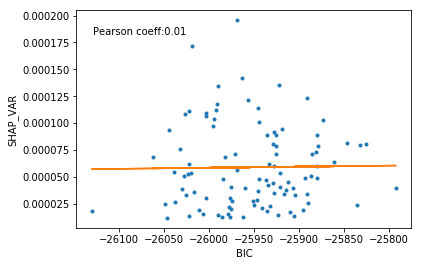

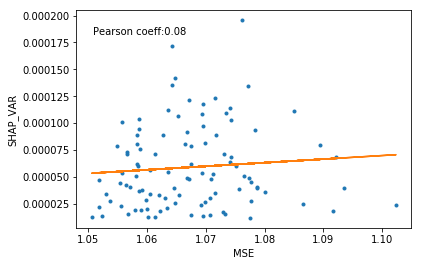

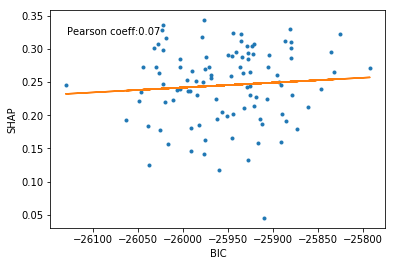

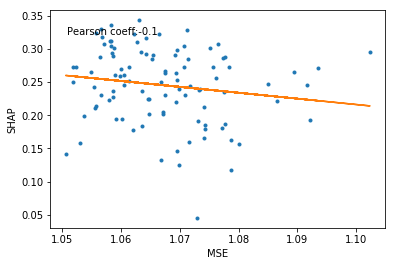

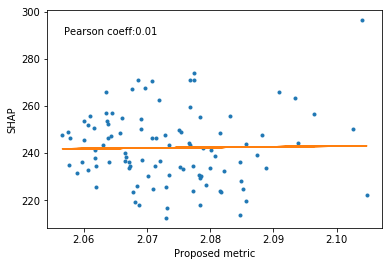

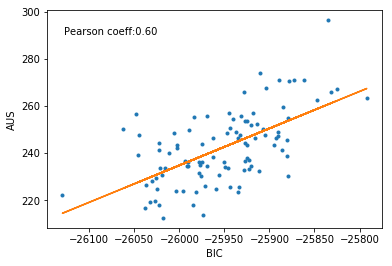

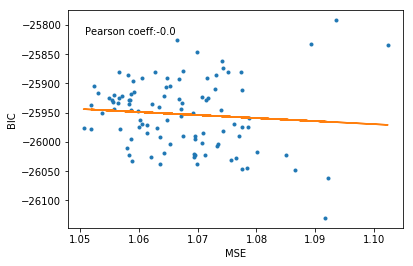

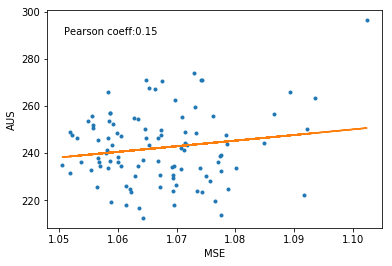

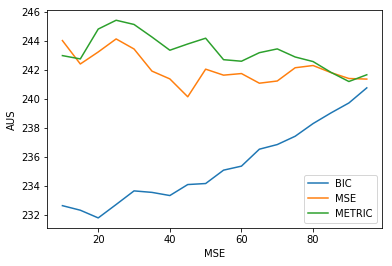

0.01799322895485309

In [48]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (VIO/np.max(VIO)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

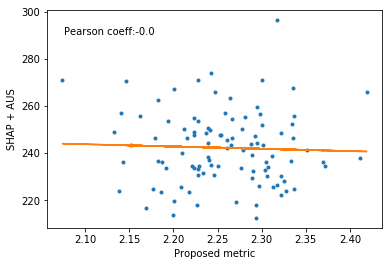

In [45]:
fig, ax = plt.subplots()

b,m = polyfit(METRIC,np.array(AUS) + np.array(SHAP_VAR), 1)
ax.plot(METRIC,np.array(AUS) + np.array(SHAP_VAR), '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,np.array(AUS) + np.array(SHAP_VAR))[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP + AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

In [46]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + np.array(MSE)
n_low = 20

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  6.71635479348597e-05
SHAP VAR Best by MSE =  4.6920847141234716e-05
SHAP VAR Best by MET =  6.71635479348597e-05
SHAP VAR Random =  5.3988637767547214e-05
SHAP Best by BIC =  0.2329928679844115
SHAP Best by MSE =  0.2587550160039326
SHAP Best by MET =  0.2329928679844115
SHAP Random =  0.2507639005221074
AUS Best by BIC =  240.16968800339828
AUS Best by MSE =  243.22524629083813
AUS Best by MET =  240.16968800339828
AUS Random =  237.74160421642742


/home/tkyono/anaconda3/lib/python3.6/site-packages/shap/explainers/deep/deep_tf.py:138: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


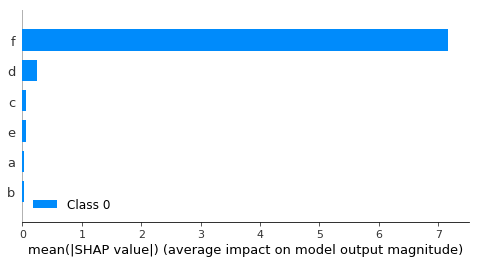

[0.033935453767588115,
 0.023987696281684002,
 0.06489302317506258,
 0.2416775709776243,
 0.05763067483655901,
 7.1588078665804025]

In [9]:
import shap
shap.initjs()
samples = 200
df = gen_data(mean = 2, var = 3)
x_train = df[inputs]
explainer_shap = shap.DeepExplainer(model=model, data=x_train)
shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
l = []
for f, feat in enumerate(inputs):
    tot = 0
    for i in shap_values[0]:
        for j in i:
            tot += np.abs(j[f])
    l.append(tot/samples)
l

